In [116]:
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join as pj
from os.path import split as ps
from tifffile import imread
from skimage.restoration import denoise_nl_means, estimate_sigma
from glob import glob
import re
from csbdeep.models import CARE
from csbdeep.utils import plot_some
%matplotlib inline

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from csbdeep.utils import normalize

# Tables

## Consolidate summary csvs

In [157]:
def consolidate_tables(ddir, outfile):
    df_ls = [pd.read_csv(f) for f in glob(pj(ddir, '*summary.csv'))]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
    df_ls.append(df_ls.append(pd.read_csv(pj(ddir, 'paper_results.csv'))))

    for df, x in zip(df_ls, ['replication', 'original']):
        df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False, float_format='%.5f')


outs = ['tables/planaria_test_data_summary.csv', 'tables/beetle_test_data_summary.csv']
ddirs = ['planaria_results', 'beetle_results']

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)


## Cosolidate raw csvs

In [128]:
def consolidate_tables(ddir, outfile):
    df_ls = [pd.read_csv(f) for f in glob(pj(ddir, '*raw.csv'))]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
    df_ls.append(df_ls.append(pd.read_csv(pj(ddir, 'paper_results.csv'))))

    for df, x in zip(df_ls, ['replication', 'original']):
        df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False)


outs = ['tables/planaria_test_data_raw.csv', 'tables/beetle_test_data_raw.csv']
ddirs = ['planaria_results', 'beetle_results']

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)


## Write RMSE and SSIM wide tables

In [169]:
def _write_wide_tables(df, table_out):
    df = df.drop('std', axis=1)
    df = pd.pivot_table(df, columns=['metric', 'output'], index='condition')

    df.columns = df.columns.droplevel()
    display(df.head())
    df.to_csv(table_out)
    
long = ['tables/planaria_test_data_summary.csv', 'tables/beetle_test_data_summary.csv']
df_ls = [pd.read_csv(f) for f in long]
wide = ['tables/planaria_wide.csv', 'tables/beetle_wide.csv']

for df, name in zip(df_ls, wide):
    _write_wide_tables(df, name)


metric          rmse                                                        \
output      beetle-1    input     nlm paper_input paper_network planaria-1   
condition                                                                    
condition_1  0.06538  0.21048  0.1766     0.08384       0.03768    0.02868   
condition_2  0.07716  0.26055     NaN     0.08818       0.03942    0.03607   
condition_3  0.28242  0.34852     NaN     0.09103       0.04780    0.05468   

metric                                ssim                                \
output      planaria-3 planaria-4 beetle-1    input      nlm paper_input   
condition                                                                  
condition_1    0.02895    0.03184  0.60107  0.11773  0.29578     0.21176   
condition_2    0.03662    0.03661  0.50297  0.08548      NaN     0.17071   
condition_3    0.05514    0.05828  0.12025  0.05303      NaN     0.14415   

metric                                                      
output      paper_network planaria-1 planaria-3 planaria-4  
condition                                                   
condition_1       0.70774    0.90556    0.90007    0.87298  
condition_2       0.70803    0.84428    0.87815    0.86077  
condition_3       0.60972    0.65758    0.68133    0.65351

metric          rmse                                                       \
output      beetle-1 beetle-2    input      nlm paper_input paper_network   
condition                                                                   
condition_1  0.15899  0.16962  0.15922  0.15954     0.09556       0.03301   
condition_2  0.12944  0.13844  0.12552  0.12686     0.08910       0.02751   
condition_3  0.10228  0.10889  0.09226  0.09500     0.07629       0.02356   

metric                                           ssim                    \
output      planaria-1 planaria-3 planaria-4 beetle-1 beetle-2    input   
condition                                                                 
condition_1    0.15237    0.15351    0.14287  0.16884  0.06984  0.07715   
condition_2    0.11953    0.12155    0.11140  0.29160  0.11991  0.12712   
condition_3    0.08833    0.09206    0.08269  0.50745  0.23032  0.23385   

metric                                                                \
output           nlm paper_input paper_network planaria-1 planaria-3   
condition                                                              
condition_1  0.08183     0.17048       0.88278    0.11063    0.10311   
condition_2  0.13428     0.22931       0.90670    0.19436    0.18280   
condition_3  0.24528     0.36174       0.92217    0.36839    0.34747   

metric                  
output      planaria-4  
condition               
condition_1    0.15098  
condition_2    0.25372  
condition_3    0.44856

In [104]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
df = df_ls[0]
df = df.drop('std', axis=1)

outputs = ['planaria-1', 'planaria-3']
_outputs = ['input'] + outputs + ['paper_input', 'paper_network']

df = df[df['output'].isin(_outputs)]

df = pd.pivot_table(df, columns=['metric', 'output'], index='condition')
df.columns = df.columns.droplevel()
df.head()


metric          rmse                                                     ssim  \
output         input paper_input paper_network planaria-1 planaria-3    input   
condition                                                                       
condition_1  0.21048     0.08384       0.03768    0.02868    0.02895  0.11773   
condition_2  0.26055     0.08818       0.03942    0.03607    0.03662  0.08548   
condition_3  0.34852     0.09103       0.04780    0.05468    0.05514  0.05303   

metric                                                       
output      paper_input paper_network planaria-1 planaria-3  
condition                                                    
condition_1     0.21176       0.70774    0.90556    0.90007  
condition_2     0.17071       0.70803    0.84428    0.87815  
condition_3     0.14415       0.60972    0.65758    0.68133

# Final Figures

## Consolidate tables

In [23]:
def consolidate_tables(glob_str, outfile):
    df_ls = [pd.read_csv(f) for f in glob(glob_str)]
    df_ls = [pd.concat(df_ls, ignore_index=True).drop_duplicates()]
    
    if 'summary' in glob_str:
        df_ls.append(
            df_ls.append(pd.read_csv(
                pj(os.path.dirname(glob(glob_str)[0]), 'paper_results.csv'))
            )
        )  
        for df, x in zip(df_ls, ['replication', 'original']):
            df['study'] = x 

    df = pd.concat(df_ls,  sort=True)
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    df.to_csv(outfile, index=False)


outs = ['tables/planaria_test_data_raw.csv',
        'tables/planaria_test_data_summary.csv',
        'tables/beetle_test_data_raw.csv',
        'tables/beetle_test_data_summary.csv']
ddirs = ['planaria_results/2019-04-16-test_raw*.csv',
         'planaria_results/2019-04-16-test_summary*.csv',
         'beetle_results/2019-04-16-test_raw.csv',
         'beetle_results/2019-04-16-test_summary.csv',
        ]

for ddir, out in zip(ddirs, outs):
    consolidate_tables(ddir, out)

# correct planaria-8 >> planaria-batch8
for out in outs[:2]:
    df = pd.read_csv(out)
    df.loc[df['output'] == 'planaria-8', 'output'] = 'planaria-batch8'
    df.to_csv(out, index=False)

## Accuracy
- worm batch
- worm step
- worm replication
- beetle replication
- worm generalization
- beetle generalization

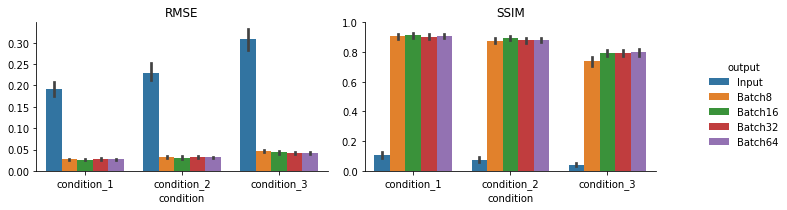

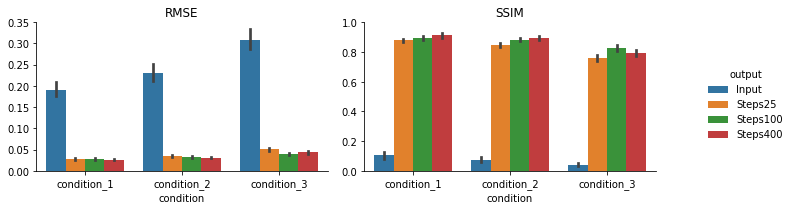

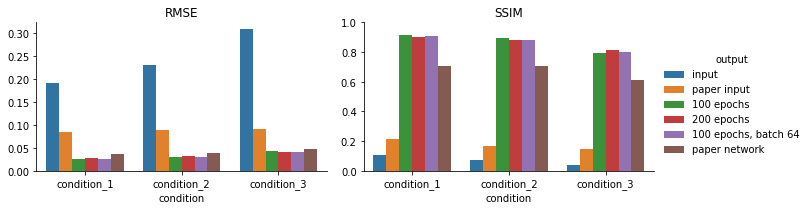

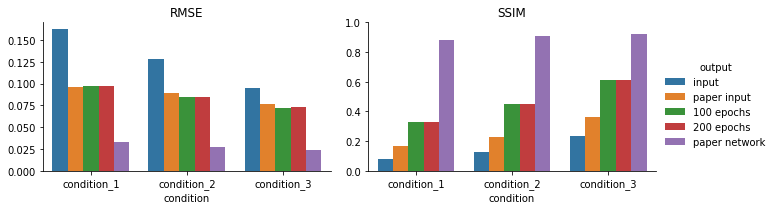

['input' 'planaria-steps100' 'planaria-steps25' 'planaria-3' 'planaria-1'
 'beetle-1' 'beetle-2' 'planaria-batch8' 'planaria-batch32'
 'planaria-batch64']


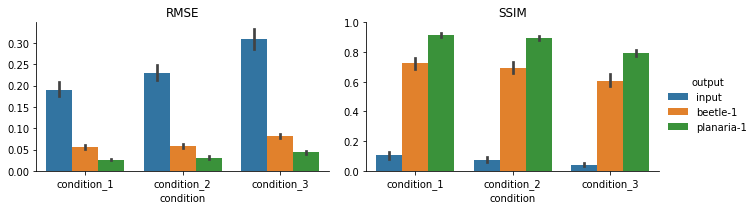

['input' 'planaria-1' 'planaria-4' 'beetle-1' 'beetle-2']


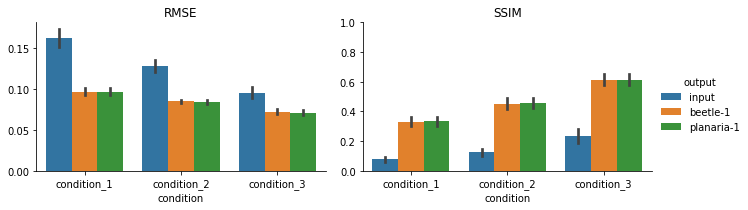

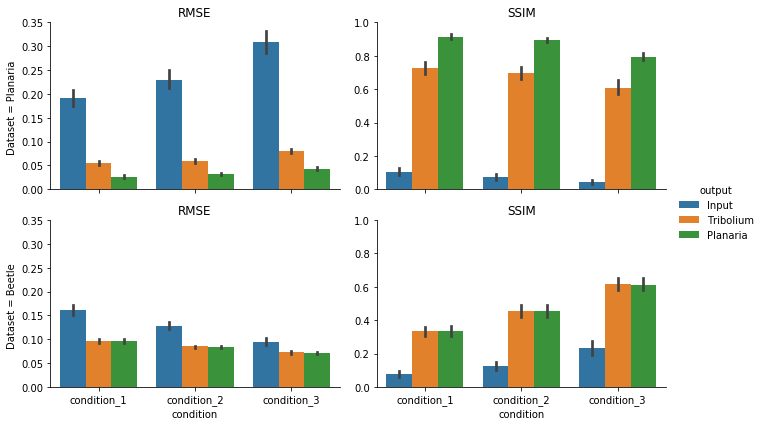

In [113]:
%run '6_figures_tables.py'

## Tables

In [100]:
%run 6_figures_tables.py

In [96]:
df = pd.read_csv('tables/planaria_test_data_summary.csv')
df = df.drop('std', axis=1)
outs = ['input',
        'planaria-1', 
        'paper_input', 'paper_network'
       ]
df = df[df['output'].isin(outs)]
df.pivot_table(index='condition', columns=['metric', 'output'], values='mean')

metric           rmse                                           ssim  \
output          input paper_input paper_network planaria-1     input   
condition                                                              
condition_1  0.190677    0.083837      0.037680   0.026660  0.104756   
condition_2  0.230190    0.088184      0.039419   0.031329  0.075128   
condition_3  0.308390    0.091028      0.047804   0.043468  0.042627   

metric                                            
output      paper_input paper_network planaria-1  
condition                                         
condition_1    0.211759      0.707738   0.914385  
condition_2    0.170711      0.708026   0.895864  
condition_3    0.144146      0.609718   0.793440

# Plots

## Graphs

In [106]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
df = df_ls[0]
df.head()

,condition,mean,metric,output,std,study
0,condition_1,0.06538,rmse,beetle-1,0.01124,replication
1,condition_1,0.60107,ssim,beetle-1,0.06290,replication
2,condition_1,0.17660,rmse,nlm,0.04909,replication
3,condition_1,0.29578,ssim,nlm,0.12494,replication
4,condition_1,0.02868,rmse,planaria-1,0.00553,replication


## Using summary

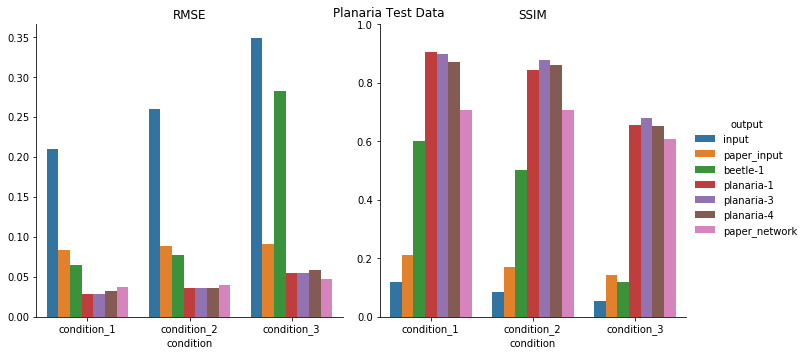

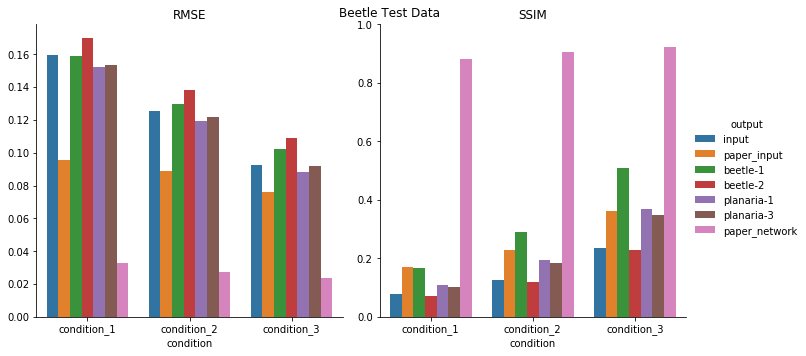

In [155]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_summary.csv',
                                  'tables/beetle_test_data_summary.csv']]
no = ['planaria-4']

df_ls[1] = df_ls[1][~df_ls[1]['output'].isin(no)]
# df_ls[1] = [df_ls[[~df['output'].isin(no)] for df in df_ls]

            
for df, name in zip(df_ls, ['Planaria Test Data', 'Beetle Test Data']):
    cols = df['output'].unique()
    pop = ['input', 'paper_input']
    cols = [x for x in sorted(cols) if x not in pop + ['nlm', 'paper_network']]
    cols = pop + cols + ['paper_network']


    g = sns.catplot(x='condition', y='mean', hue='output', 
                    kind='bar',
                    col='metric',
                    hue_order=cols,
                    sharey=False, data=df)
    
    g.axes[0,1].set_ylim(0,1)
    g.set_ylabels('')
    g.axes[0,0].set_title('RMSE')
    g.axes[0,1].set_title('SSIM')
    g.fig.suptitle(name)

## Using raw
I.e., variance so we can do boxplots

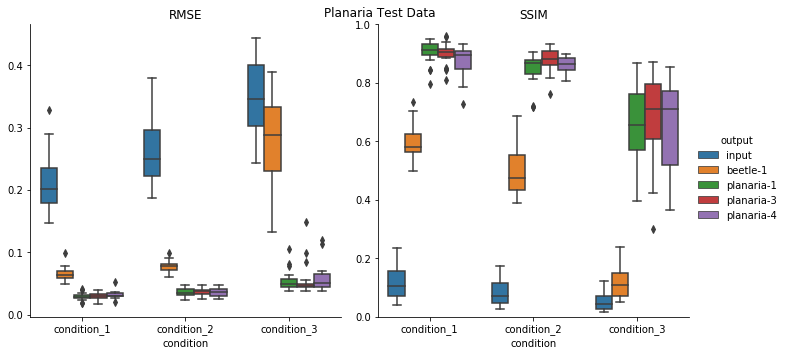

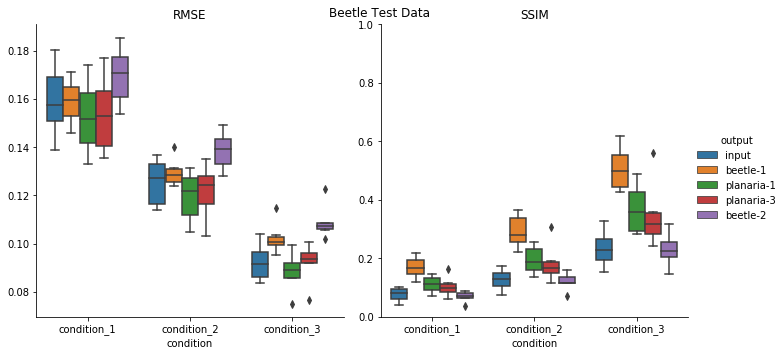

In [154]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_raw.csv',
                                  'tables/beetle_test_data_raw.csv']]
df_ls[1] = df_ls[1][~df_ls[1]['output'].isin(no)]

for df, name in zip(df_ls, ['Planaria Test Data', 'Beetle Test Data']):

    cols = df['output'].unique()
    pop = ['input', 'beetle-1', 'planaria-1']
    cols = [x for x in cols if x not in pop + ['nlm']]
    cols = pop + cols


    g = sns.catplot(x='condition', y='value', hue='output', 
                    kind='box',
                    col='metric',
                    hue_order=cols,
                    sharey=False, data=df)
    g.axes[0,1].set_ylim(0,1)
    g.set_ylabels('')
    g.axes[0,0].set_title('RMSE')
    g.axes[0,1].set_title('SSIM')
    g.fig.suptitle(name)

## 15 Apr, now with linear transform

- still slightly questionable normalization
    - default CARE predict norm
    - pNorm AND affine rescaling of prediction (I think the methods say only do the affine rescale)

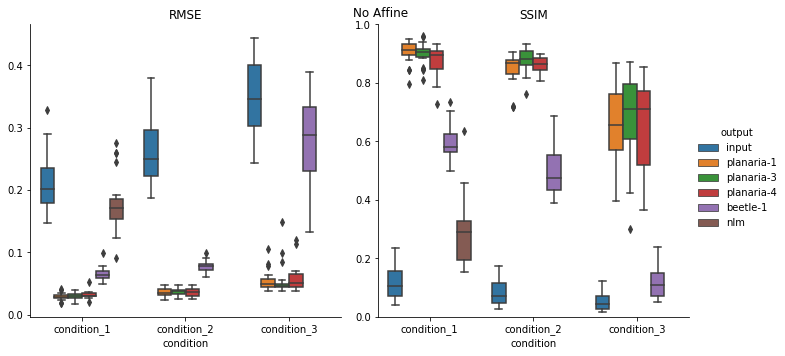

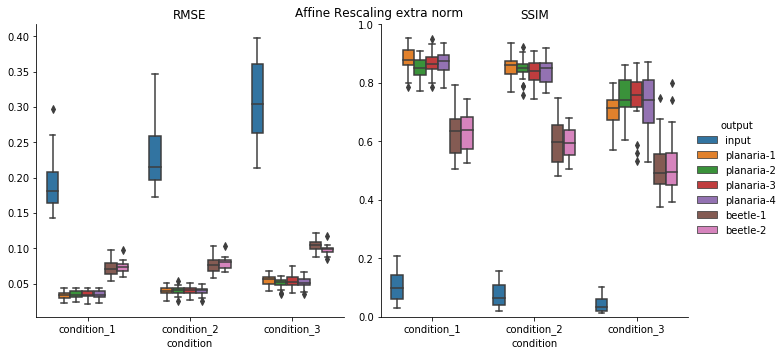

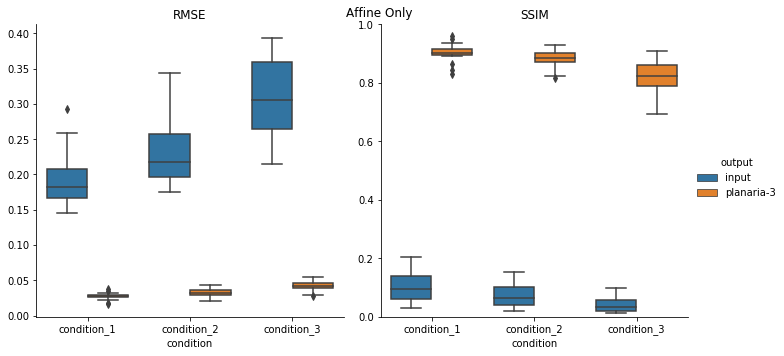

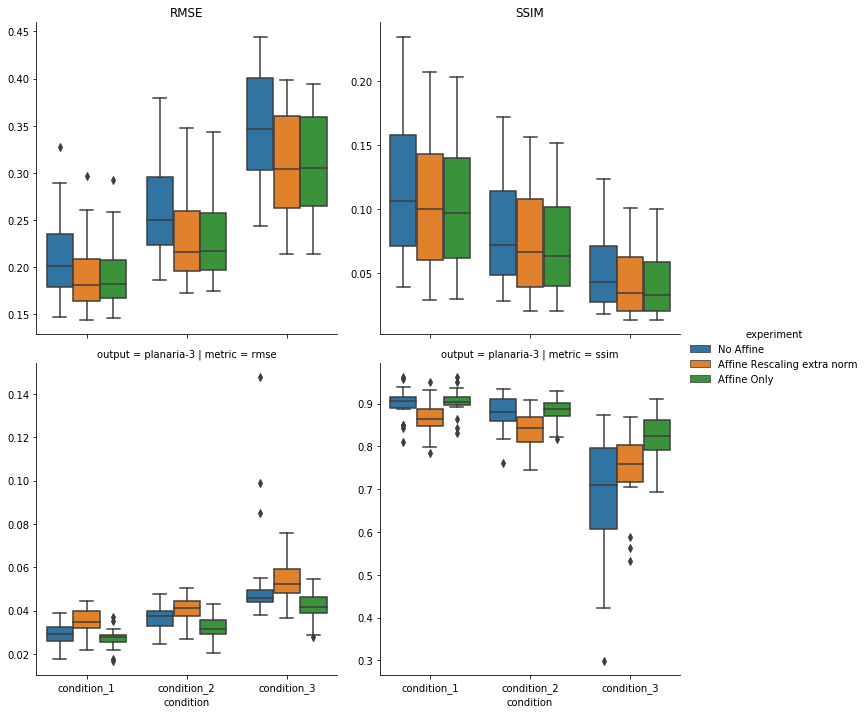

In [9]:
df_ls = [pd.read_csv(f) for f in ['tables/planaria_test_data_raw.csv',
                                  'planaria_results/2019-04-15-test_raw.csv',
                                  'planaria_results/2019-04-16-test_raw.csv']]

for df, name in zip(df_ls, ['No Affine', 'Affine Rescaling extra norm',
                           'Affine Only']):
    df['experiment'] = name
    # drop the dates form model names
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]
    g = sns.catplot(x='condition', y='value', hue='output', 
                    kind='box',
                    col='metric',
#                     hue_order=cols,
                    sharey=False, data=df)
    g.axes[0,1].set_ylim(0,1)
    g.set_ylabels('')
    g.axes[0,0].set_title('RMSE')
    g.axes[0,1].set_title('SSIM')
    g.fig.suptitle(name)

df = pd.concat(df_ls, sort=False)
df = df[df['output'].isin(['planaria-3', 'input'])]

g = sns.catplot(x='condition', y='value', hue='experiment', 
                kind='box',
                col='metric',
                row='output',
                sharey=False, data=df)
g.set_ylabels('')
g.axes[0,0].set_title('RMSE')
g.axes[0,1].set_title('SSIM')
# g.fig.suptitle('Planaria-3 200 epoch')
plt.show()

## Beetle 

Last ditch effort to get similar to published values

### normalized inputs
- feed the model xn (vs x)
- model normalizer, `do_after=False`

Text(0.5,0.98,'Test data = beetle, normalized inputs')

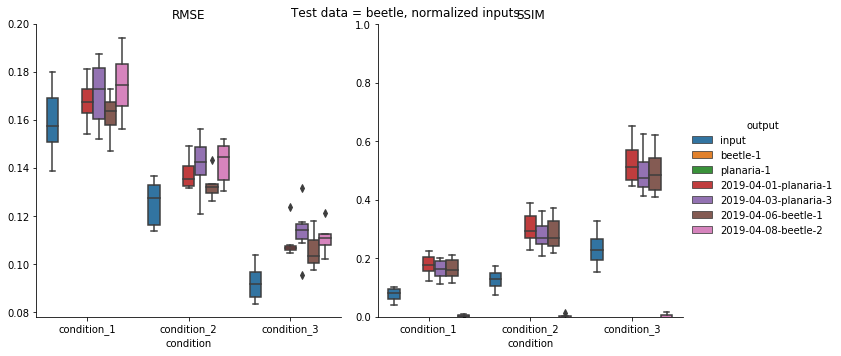

In [9]:
# Plot the results
df = pd.read_csv('beetle_results/2019-04-14-test_raw-2.csv')

cols = df['output'].unique()
pop = ['input', 'beetle-1', 'planaria-1']
cols = [x for x in cols if x not in pop + ['nlm']]
cols = pop + cols


g = sns.catplot(x='condition', y='value', hue='output', 
                kind='box',
                col='metric',
                hue_order=cols,
                sharey=False, data=df)
g.axes[0,1].set_ylim(0,1)
g.set_ylabels('')
g.axes[0,0].set_title('RMSE')
g.axes[0,1].set_title('SSIM')
g.fig.suptitle('Test data = beetle, normalized inputs')

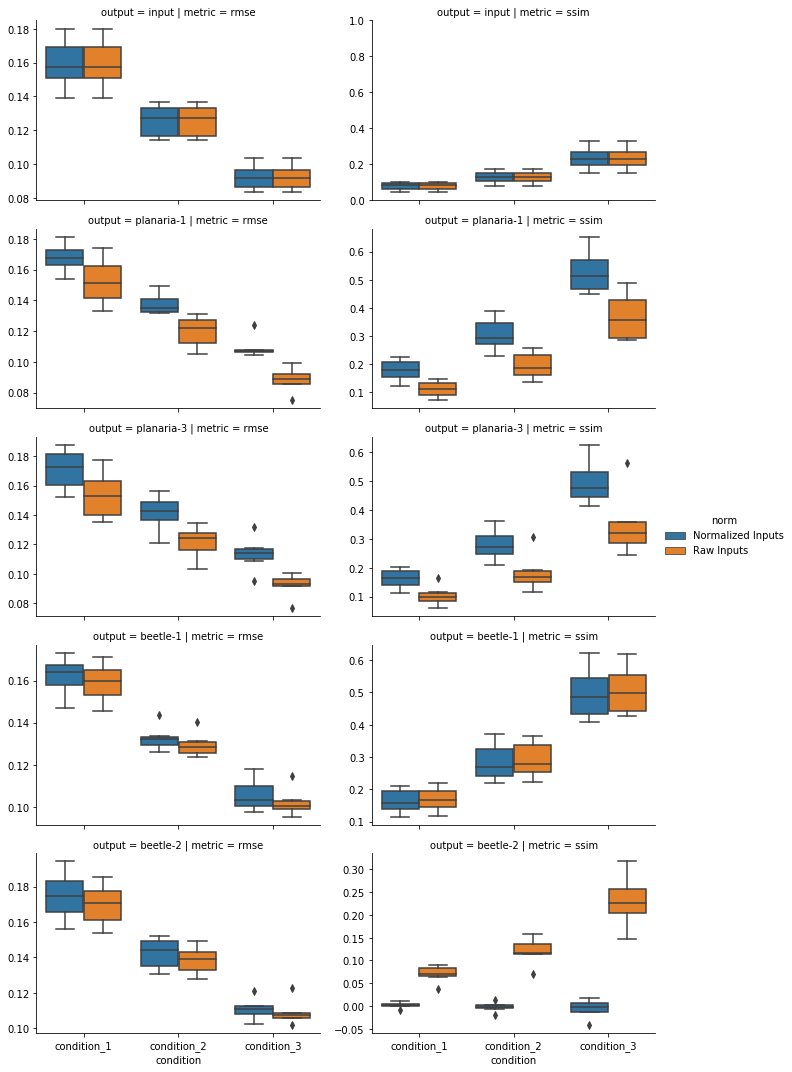

In [33]:
# See how each model is affected by the normalization change
df_ls = [pd.read_csv(f) for f in ['beetle_results/2019-04-14-test_raw-2.csv',
                                  'tables/beetle_test_data_raw.csv']]

for df, name in zip(df_ls, ['Normalized Inputs', 'Raw Inputs']):
    df['norm'] = name
    df['output'] = [re.split('\d{4}-\d{2}-\d{2}-', o)[-1] for o in df['output']]

df = pd.concat(df_ls, sort=True)
df = df[df['output'].isin(df_ls[0]['output'].unique())]

g = sns.catplot(x='condition', y='value', 
                height=3, aspect=16/10,
                kind='box',
                col='metric',
                hue='norm',
                row='output',
#                 hue_order=cols,
                sharey=False, data=df)
g.axes[0,1].set_ylim(0,1)
g.set_ylabels('')
g.fig.figure
plt.show()


#### Plot beetle-2 norm/raw

In [101]:
def load_test_data(test_dir):
    """ Return dict w/ keys condition 1--3 and y. 
    Each value is a list of samples. Each sample is a np 3darray z stack of one
    sample, axes ZYX
    """
    im_files = os.listdir(test_dir)
    data = {'condition_%d' %(i+1) : [] for i in range(3)}
    y = []
    im_names = []

    for f in im_files:
        im = imread(pj(test_dir, f))
        for i in range(3):
            data['condition_%d' %(i+1)].append(im[i])
        y.append(im[-1])

    return data, y

def plot(x, y, model, axes='ZYX', z_ix=0, debug=False):

    xn = util.percentile_norm(x, axes)
    yn = util.percentile_norm(y, axes)
    pred = model.predict(
        x, axes, normalizer=util.PercentileNormalizer(do_after=False),
        n_tiles=(1,2,2))[z_ix]
    predn = model.predict(
        xn, axes, normalizer=util.PercentileNormalizer(do_after=False),
        n_tiles=(1,2,2))[z_ix]
    
    ims = np.vstack((
        np.stack([x[z_ix],  yn[z_ix]]),
        np.stack([[pred, predn]])
    ))
    title_list = [['xn', 'yn'], ['beetle-2(x)', 'beetle-2(xn)']]
    if debug:
        return ims, title_list
    else:
        util.plot_some(ims, title_list=title_list)

def get_2d(x, im_ix=0, z_ix=0):
    return x[im_ix][z_ix]
def get_3d(x, im_ix=0, z_ix=0):
    return x[im_ix]

data, Y = load_test_data('data/Denoising_Tribolium/test_data/')
x = get_3d(data['condition_3'])
y = get_3d(Y)


m = CARE(config=None, name='2019-04-08-beetle-2', basedir='models')
model = m
# plt.figure(figsize=(16,16))
# plt.rcParams['figure.figsize'] = 16,10

Loading network weights from 'weights_best.h5'.


In [ ]:
# WHY CAN'T I MAKE TALL PLOTS
# a, b = plot(x, y, m, debug=True)

z_ix = 0
axes = 'ZYX'

xn = util.percentile_norm(x, axes)
yn = util.percentile_norm(y, axes)
pred = model.predict(
    x, axes, normalizer=util.PercentileNormalizer(do_after=False),
    n_tiles=(1,2,2))[z_ix]
predn = model.predict(
    xn, axes, normalizer=util.PercentileNormalizer(do_after=False),
    n_tiles=(1,2,2))[z_ix]
xn = xn[z_ix]
yn = yn[z_ix]

In [128]:
def to_color(arr, pmin=1, pmax=99.8, gamma=1., colors=((0, 1, 0), (1, 0, 1), (0, 1, 1))):
    """Converts a 2D or 3D stack to a colored image (maximal 3 channels).

    Parameters
    ----------
    arr : numpy.ndarray
        2D or 3D input data
    pmin : float
        lower percentile, pass -1 if no lower normalization is required
    pmax : float
        upper percentile, pass -1 if no upper normalization is required
    gamma : float
        gamma correction
    colors : list
        list of colors (r,g,b) for each channel of the input

    Returns
    -------
    numpy.ndarray
        colored image
    """
    if not arr.ndim in (2,3):
        raise ValueError("only 2d or 3d arrays supported")

    if arr.ndim ==2:
        arr = arr[np.newaxis]

    ind_min = np.argmin(arr.shape)
    arr = np.moveaxis(arr, ind_min, 0).astype(np.float32)

    out = np.zeros(arr.shape[1:] + (3,))

    eps = 1.e-20
    if pmin>=0:
        mi = np.percentile(arr, pmin, axis=(1, 2), keepdims=True)
    else:
        mi = 0

    if pmax>=0:
        ma = np.percentile(arr, pmax, axis=(1, 2), keepdims=True)
    else:
        ma = 1.+eps

    arr_norm = (1. * arr - mi) / (ma - mi + eps)


    for i_stack, col_stack in enumerate(colors):
        if i_stack >= len(arr):
            break
        for j, c in enumerate(col_stack):
            out[..., j] += c * arr_norm[i_stack]

    return np.clip(out, 0, 1)
def color_image(a):
    return np.stack(map(to_color,a)) if 1<a.shape[-1]<=3 else np.squeeze(a)
def max_project(a):
    return np.max(a,axis=1) if (a.ndim==4 and not 1<=a.shape[-1]<=3) else a

a = np.stack(
    (
        np.stack((xn, yn)), np.stack((pred, predn))
    )
)
b = [['xn', 'yn'], ['beetle-2(x)', 'beetle-2(xn)']]

a = map(color_image,a)
a = map(max_project,a)
a = list(a)
h = len(a)
w = len(a[0])
print(h, w)

2 2


In [ ]:
dpis = [120]
figsize = (16,5)

for dpi in dpis:
    plt.figure(figsize=figsize, dpi=dpi)
    plot_some(a, title_list=b)
    f.suptitle('Figsize %s, DPI %d' %(str(figsize), dpi))
    plt.show()

TypeError: object of type 'map' has no len()